In [146]:
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.transforms
import seaborn as sns
import math
from math import sqrt, factorial
import re
from itertools import groupby
import scipy
import random
from decimal import Decimal
from operator import itemgetter
#some functions that help find angles between planes

#https://keisan.casio.com/exec/system/1223596129
def plane_eq(points):
    p0 = points[0,:]
    p1 = points[1,:]
    p2 = points[2,:]
    v1 = [p1[0]-p0[0], p1[1]-p0[1], p1[2]-p0[2]]
    v2 = [p2[0]-p0[0], p2[1]-p0[1], p2[2]-p0[2]]
    abc = np.cross(v1, v2)
    d = np.array([abc[0]*p0[0], abc[1]*p0[1], abc[2]*p0[2]])
    return abc, d
# Function to find Angle
def distance(a1, b1, c1, a2, b2, c2):
     
    d = ( a1 * a2 + b1 * b2 + c1 * c2 )
    e1 = math.sqrt( a1 * a1 + b1 * b1 + c1 * c1)
    e2 = math.sqrt( a2 * a2 + b2 * b2 + c2 * c2)
    d = d / (e1 * e2)
    A = math.degrees(math.acos(d))
    return A

def angle(a1, b1, a2, b2):
     
    d = ( a1 * a2 + b1 * b2)
    e1 = math.sqrt( a1 * a1 + b1 * b1)
    e2 = math.sqrt( a2 * a2 + b2 * b2)
    d = d / (e1 * e2)
    A = math.degrees(math.acos(d))
    return A
def closest(lst, K):  
    return lst[min(range(len(lst)), key = lambda i: abs(lst[i]-K))]

In [147]:
#get directories and open separated datasets

time_interval = 10 #sec/frame

lmax = 10

datadir = 'E:/Aaron/Combined_Confocal_PCA_nospeedoutliers/'
savedir = datadir + 'Galvanotaxis/'
if not os.path.exists(savedir):
    os.makedirs(savedir)

FullFrame = pd.read_csv(datadir + 'Shape_Metrics_transitionPCbins.csv', index_col=0)

nbins = np.max(FullFrame[[x for x in FullFrame.columns.to_list() if 'bin' in x]].to_numpy())

#open the centers of the binned PCs
centers = pd.read_csv(datadir+'PC_bin_centers.csv', index_col=0)

#limit data to the 30C Galv experiments
TotalFrame = FullFrame[(FullFrame.Experiment == 'Galvanotaxis')].copy()
TotalFrame['Treatment'] = pd.Categorical(TotalFrame.Treatment.to_list(), categories=['Random','Pre-Galvanotaxis'], ordered=True)
TotalFrame['Temperature'] = pd.Categorical(TotalFrame.Temperature.to_list(), categories=['30C','37C'], ordered=True)


<AxesSubplot:xlabel='frame', ylabel='Angular_Bias'>

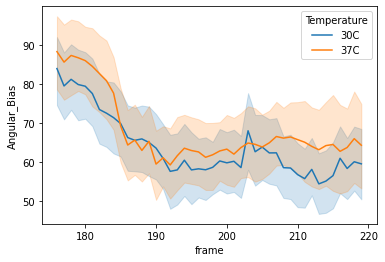

In [148]:
# ########## HOW FAST DOES THE POPULATION ALIGN TO THE FIELD ##############

angles = []
for i, row in TotalFrame.iterrows():
    angles.append(distance(row.Trajectory_X,row.Trajectory_Y,row.Trajectory_Z,-1,0,0))
#     angles.append(angle(row.Trajectory_X,row.Trajectory_Y,1,0))
TotalFrame['Angular_Bias'] = angles


sns.lineplot(data = TotalFrame[(TotalFrame.frame > 175) & (TotalFrame.frame <220)], x = 'frame', y='Angular_Bias',hue = 'Temperature')

In [149]:

#grab only the cells that I saw when the field was applied
baef = np.arange(174,186)#187)
dfe = []
for i, cell in TotalFrame.groupby('CellID'):
    cell = cell.sort_values('frame').reset_index(drop = True)
    if all([n in cell.frame.to_list() for n in baef]):
        dfe.append(cell[cell.frame.isin(baef)])
dfef = pd.concat(dfe)

print(f'There are {len(dfef.CellID.unique())} cells continuously in this time window')

There are 60 cells continuously in this time window


In [150]:
############### Get Correlation matrix #######################

#stats to remove, if any
to_remove = [i for i in TotalFrame.columns.to_list() if 'Axis' in i] 
# to_remove.extend([i for i in TotalFrame.columns.to_list() if 'Centroid' in i])
to_remove.extend([i for i in TotalFrame.columns.to_list() if 'bin' in i])
# to_remove.extend([i for i in TotalFrame.columns.to_list() if 'intensity' in i])
to_remove.extend([i for i in TotalFrame.columns.to_list() if 'shcoeff' in i])
to_remove.extend([i for i in TotalFrame.columns.to_list() if 'Trajectory' in i])
# to_remove.extend([i for i in TotalFrame.columns.to_list() if 'dist' in i])



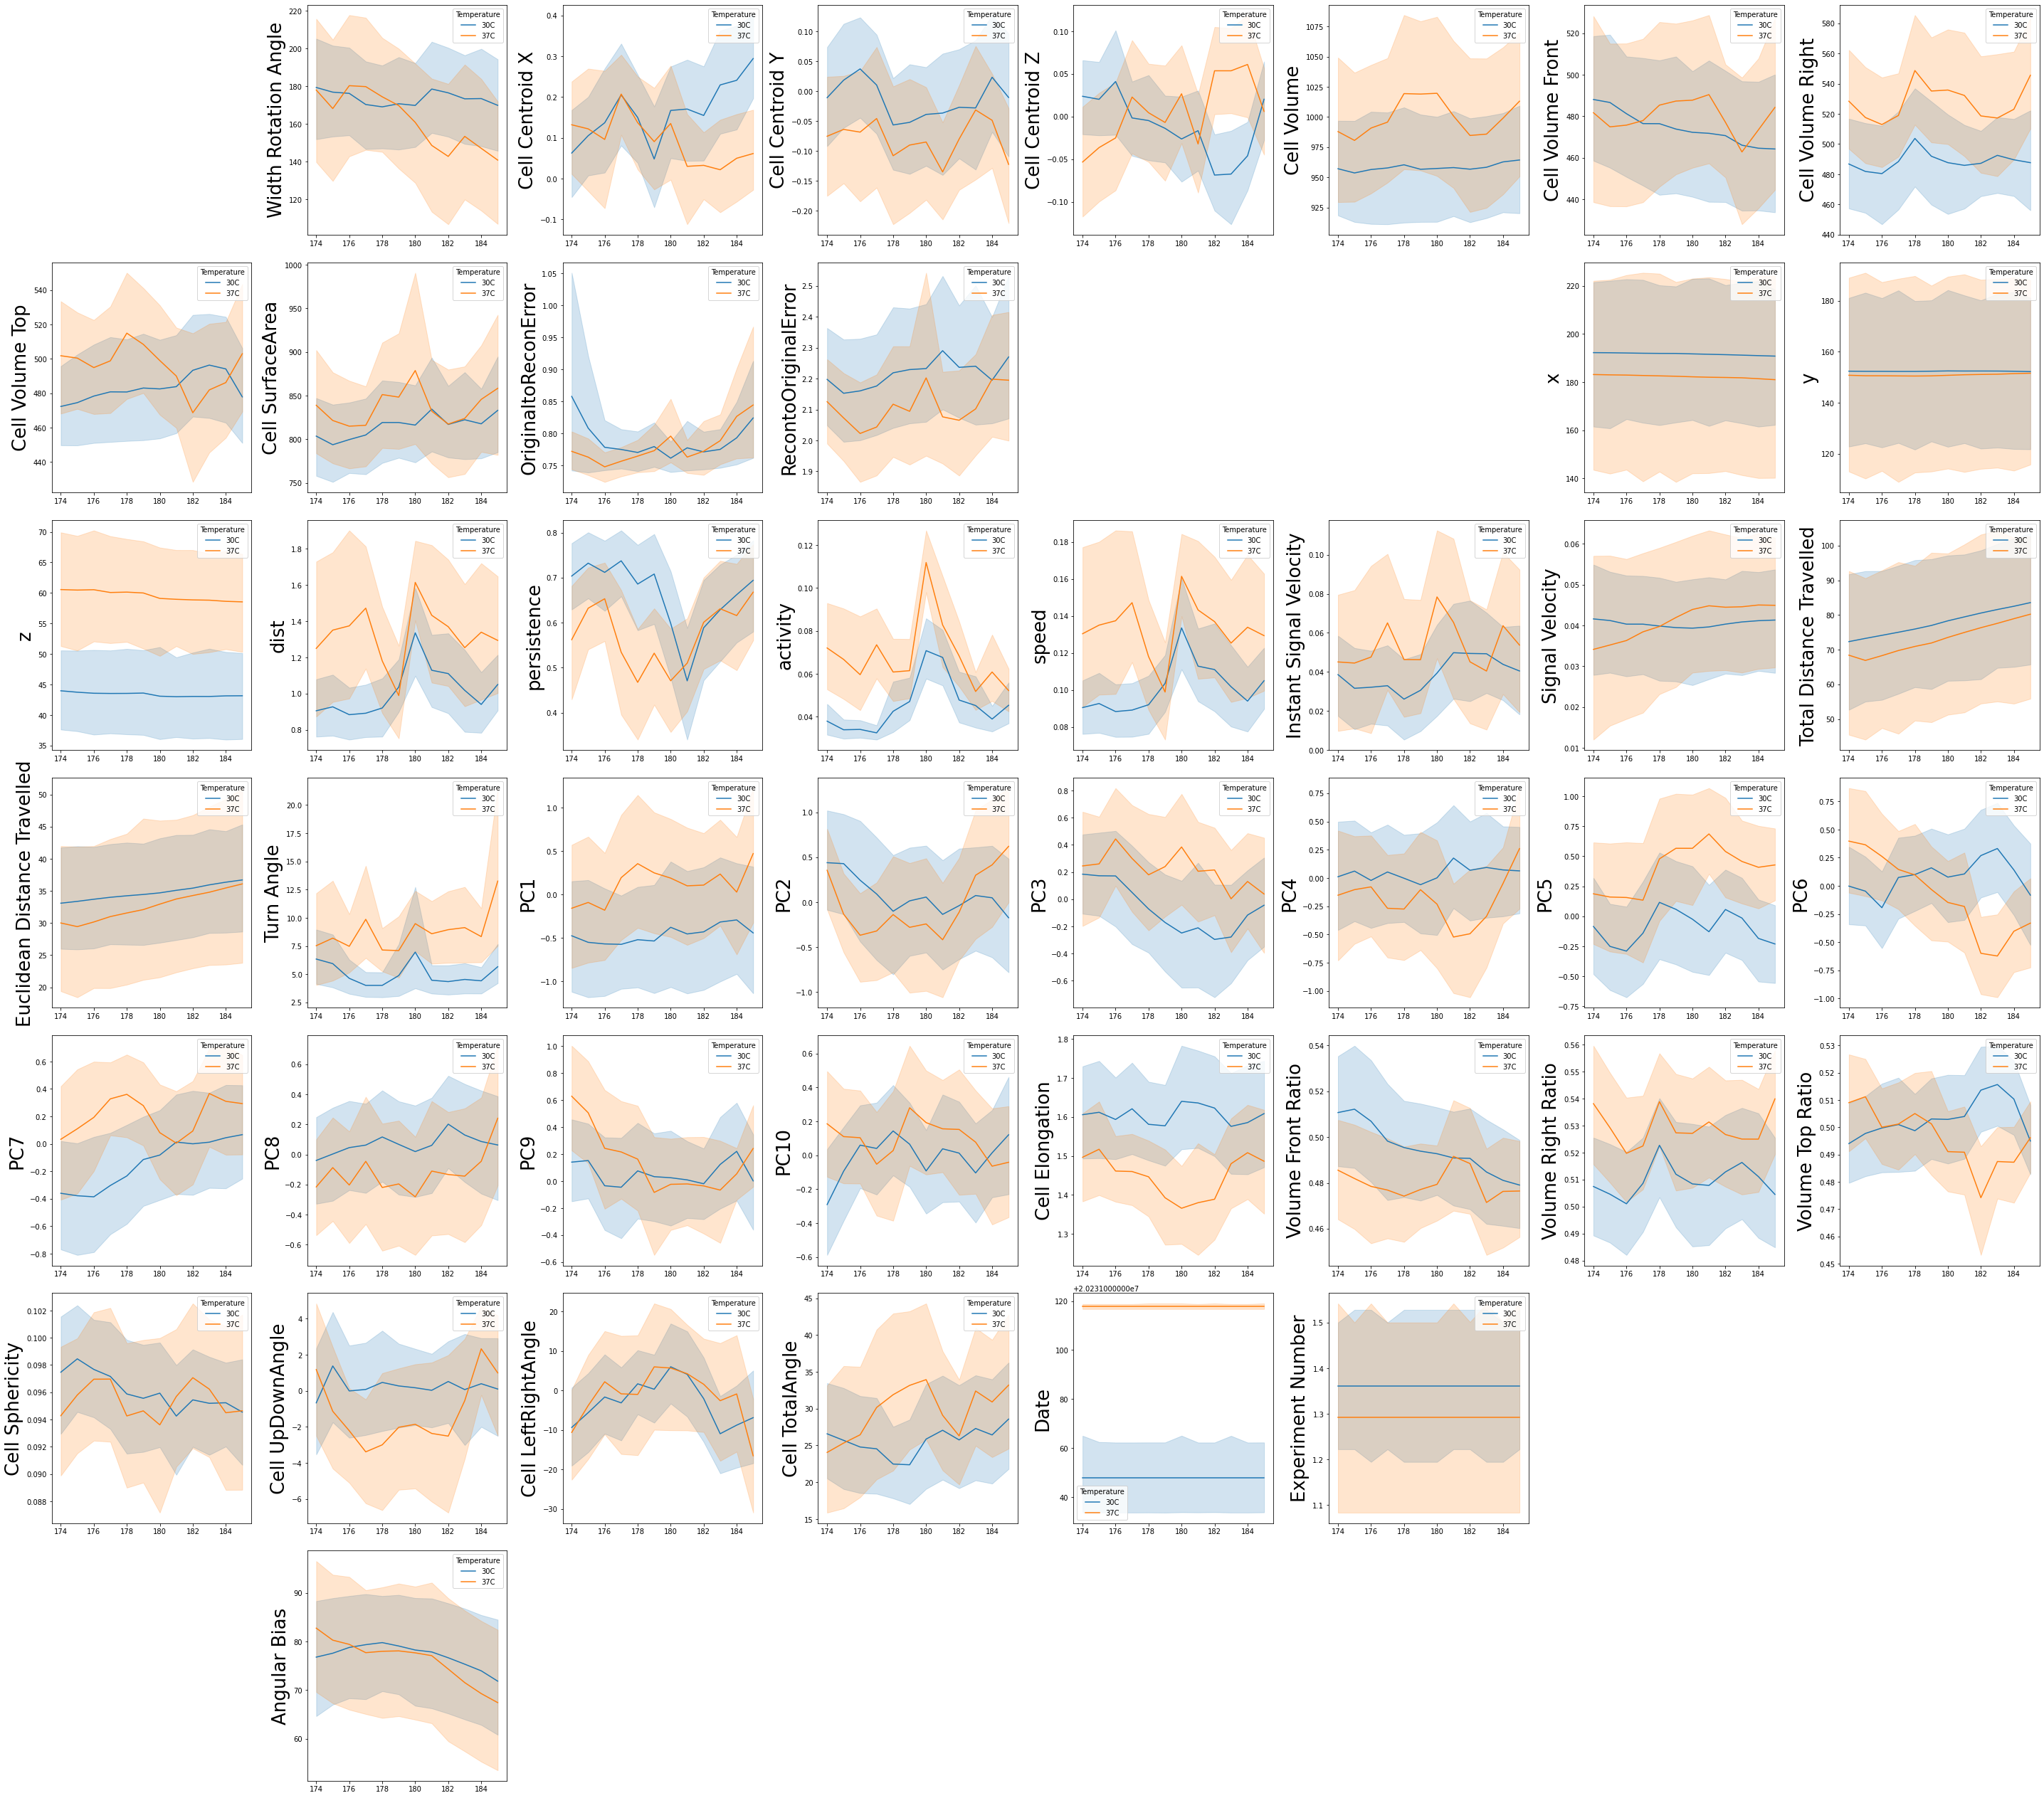

In [151]:
############## graph all of the stats for cells tracked during the EF transition ###########
moreremove = []
moreremove.extend([i for i in dfef.columns.to_list() if 'Euler' in i])
moreremove.extend([i for i in dfef.columns.to_list() if 'intensity' in i])
moreremove.extend([i for i in dfef.columns.to_list() if 'avg' in i])
moreremove.extend(['cell','CellID'])
ModeFrame = dfef.copy().drop(columns=to_remove+moreremove).reset_index()
#make subplots
sp = math.ceil(math.sqrt(len(ModeFrame.columns)))
fig, axes = plt.subplots(sp,sp,figsize=(sp*5,sp*5))

for i, ax in enumerate(axes.flatten()):
    
    if i<len(ModeFrame.columns): 
        param = ModeFrame.columns[i]
        #plot heatmap with seaborn
        if param not in ['frame', 'Treatment','Experiment','Temperature','structure','index']:
        #### use the max and the lowest non zero as min
            sns.lineplot(data = ModeFrame,
                x = 'frame',
                y = param,
                hue = 'Temperature',
                ax = ax,
            )
#         ax.set_xticklabels(
#             [round(x,1) for x in centers.PC1.to_list()],
#             fontsize = 22
#         )
#         ax.set_yticklabels(
#             [round(x,1) for x in centers.PC2.to_list()],
#             rotation=0,
#             fontsize = 22
#         )
#         #take out all axis labels except the desired ones
#         for o, l in enumerate(ax.xaxis.get_ticklabels()):
#             if o%5 != 0:
#                 l.set_visible(False)
#         for o, l in enumerate(ax.yaxis.get_ticklabels()):
#             if o%5 != 0:
#                 l.set_visible(False)
            #set axis titles
            ax.set_xlabel('')
            ax.set_ylabel(param.replace('_',' '), fontsize = 26)
        else:
            ax.remove()
    else:
        ax.remove()
plt.tight_layout()

In [152]:
############### get list of metrics that are significant by migration mode using anova ############
ModeFrame = TotalFrame.copy()
import statsmodels.api as sm 
from statsmodels.formula.api import ols 
import scipy.stats as ss
siglist = []
new_remove = to_remove.copy()
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'cell' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'frame' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'angle' in x])
# new_remove.extend([x for x in ModeFrame.columns.to_list() if 'avg' in x])
# new_remove.extend([x for x in ModeFrame.columns.to_list() if 'dist' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'activity' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'structure' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'ID' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'Experiment' in x])
# new_remove.extend([x for x in ModeFrame.columns.to_list() if 'Treatment' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'intensity' in x])
new_remove.extend(['x','y','z','OriginaltoReconError', 'RecontoOriginalError', 'Width_Rotation_Angle',
                   'Cell_Centroid_X', 'Cell_Centroid_Y', 'Cell_Centroid_Z','Temperature'])
for c in ModeFrame.drop(columns=new_remove).columns.to_list():
    if c != 'Treatment':
        # Performing two-way ANOVA 
        model = ols(f'{c} ~ C(Treatment) + C(Temperature) + C(Treatment):C(Temperature)', 
                    data=ModeFrame).fit() 
        result = sm.stats.anova_lm(model, type=2) 


        if any(result['PR(>F)'].values <0.05):
            # Print the result 
            print(c, result) 
            siglist.append(c) 
# siglist = sorted(siglist)
# from statsmodels.stats.multicomp import pairwise_tukeyhsd
# for c in siglist:
#     print(f'Name {c}', pairwise_tukeyhsd(ModeFrame[c].dropna(), ModeFrame.loc[ModeFrame[c].dropna().index.to_list()].Treatment))

# units= ['(a.u.)','(a.u.)','(µm$^3$)','(a.u.)','(a.u.)','(µm$^2$)','(µm$^3$)',
#         '(a.u.)','(a.u.)']

Cell_Volume                                   df        sum_sq       mean_sq           F  \
C(Treatment)                     1.0  1.877370e+05  1.877370e+05    6.788175   
C(Temperature)                   1.0  3.904062e+06  3.904062e+06  141.162651   
C(Treatment):C(Temperature)      1.0  3.252839e+04  3.252839e+04    1.176158   
Residual                     21240.0  5.874236e+08  2.765648e+04         NaN   

                                   PR(>F)  
C(Treatment)                 9.182768e-03  
C(Temperature)               1.878546e-32  
C(Treatment):C(Temperature)  2.781519e-01  
Residual                              NaN  
Cell_Volume_Front                                   df        sum_sq       mean_sq         F  \
C(Treatment)                     1.0  4.561234e+04  45612.339178  4.052976   
C(Temperature)                   1.0  9.382916e+02    938.291583  0.083374   
C(Treatment):C(Temperature)      1.0  3.154306e+04  31543.060251  2.802822   
Residual                     21240.0 

Turn_Angle                                   df        sum_sq       mean_sq           F  \
C(Treatment)                     1.0  3.893320e+00      3.893320    0.028701   
C(Temperature)                   1.0  5.371580e+04  53715.796677  395.979767   
C(Treatment):C(Temperature)      1.0  8.417465e+02    841.746477    6.205150   
Residual                     20814.0  2.823479e+06    135.652882         NaN   

                                   PR(>F)  
C(Treatment)                 8.654738e-01  
C(Temperature)               2.678468e-87  
C(Treatment):C(Temperature)  1.274565e-02  
Residual                              NaN  
PC1                                   df        sum_sq     mean_sq           F  \
C(Treatment)                     1.0      0.185492    0.185492    0.046991   
C(Temperature)                   1.0    908.460018  908.460018  230.141710   
C(Treatment):C(Temperature)      1.0      1.984984    1.984984    0.502859   
Residual                     21240.0  83842.649585  

Angular_Bias                                   df        sum_sq        mean_sq           F  \
C(Treatment)                     1.0  5.953408e+05  595340.843433  412.317653   
C(Temperature)                   1.0  3.114605e+04   31146.048198   21.570946   
C(Treatment):C(Temperature)      1.0  8.860700e+01      88.606997    0.061367   
Residual                     21240.0  3.066820e+07    1443.888807         NaN   

                                   PR(>F)  
C(Treatment)                 8.351200e-91  
C(Temperature)               3.430206e-06  
C(Treatment):C(Temperature)  8.043508e-01  
Residual                              NaN  


In [153]:
############### get list of metrics that are significant by migration mode using PAIRED T TESTS ############
ModeFrame = dfef.copy()
import statsmodels.api as sm 
from statsmodels.formula.api import ols 
import scipy.stats as ss
siglist = []
new_remove = to_remove.copy()
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'cell' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'frame' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'angle' in x])
# new_remove.extend([x for x in ModeFrame.columns.to_list() if 'avg' in x])
# new_remove.extend([x for x in ModeFrame.columns.to_list() if 'dist' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'activity' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'structure' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'ID' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'Experiment' in x])
# new_remove.extend([x for x in ModeFrame.columns.to_list() if 'Treatment' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'intensity' in x])
new_remove.extend(['x','y','z','OriginaltoReconError', 'RecontoOriginalError', 'Width_Rotation_Angle',
                   'Cell_Centroid_X', 'Cell_Centroid_Y', 'Cell_Centroid_Z','Temperature'])
ptlist = []
for c in ModeFrame.drop(columns=new_remove).columns.to_list():
    if c != 'Treatment':
        # Performing two-way ANOVA
        for te in ModeFrame.Temperature.unique():
            stat, pval = ss.ttest_rel(ModeFrame[c][(ModeFrame.Treatment == 'Random') & (ModeFrame.Temperature == te)], 
                                          ModeFrame[c][(ModeFrame.Treatment == 'Pre-Galvanotaxis') & (ModeFrame.Temperature == te)])
            ptlist.append({'Temperature': te,
                           'Metric': c,
                          'p_value': pval})
        
ptdf = pd.DataFrame(ptlist)
ptdf[ptdf.p_value<0.05]
#         if any(result['PR(>F)'].values <0.05):
#             # Print the result 
#             print(c, result) 
#             siglist.append(c) 
# siglist = sorted(siglist)
# from statsmodels.stats.multicomp import pairwise_tukeyhsd
# for c in siglist:
#     print(f'Name {c}', pairwise_tukeyhsd(ModeFrame[c].dropna(), ModeFrame.loc[ModeFrame[c].dropna().index.to_list()].Treatment))

# units= ['(a.u.)','(a.u.)','(µm$^3$)','(a.u.)','(a.u.)','(µm$^2$)','(µm$^3$)',
#         '(a.u.)','(a.u.)']

Temperature                        Metric       p_value
2          30C             Cell_Volume_Front  3.735684e-02
7          37C               Cell_Volume_Top  1.327441e-02
8          30C              Cell_SurfaceArea  3.338826e-02
10         30C                          dist  1.014447e-04
14         30C                         speed  1.014447e-04
20         30C       Instant_Signal_Velocity  5.512216e-03
24         30C      Total_Distance_Travelled  1.571528e-94
26         30C  Euclidean_Distance_Travelled  1.930811e-11
34         30C                           PC3  1.029219e-03
39         37C                           PC5  4.456408e-02
41         37C                           PC6  1.072924e-06
42         30C                           PC7  2.721222e-03
47         37C                           PC9  1.971945e-02
52         30C            Volume_Front_Ratio  6.920610e-03
56         30C              Volume_Top_Ratio  3.946861e-02
57         37C              Volume_Top_Ratio  5.841543e-05
58         30C               Cell_Sphericity  8.091640e-03
68         30C                  Angular_Bias  2.489471e-02
69         37C                  Angular_Bias  3.745079e-02

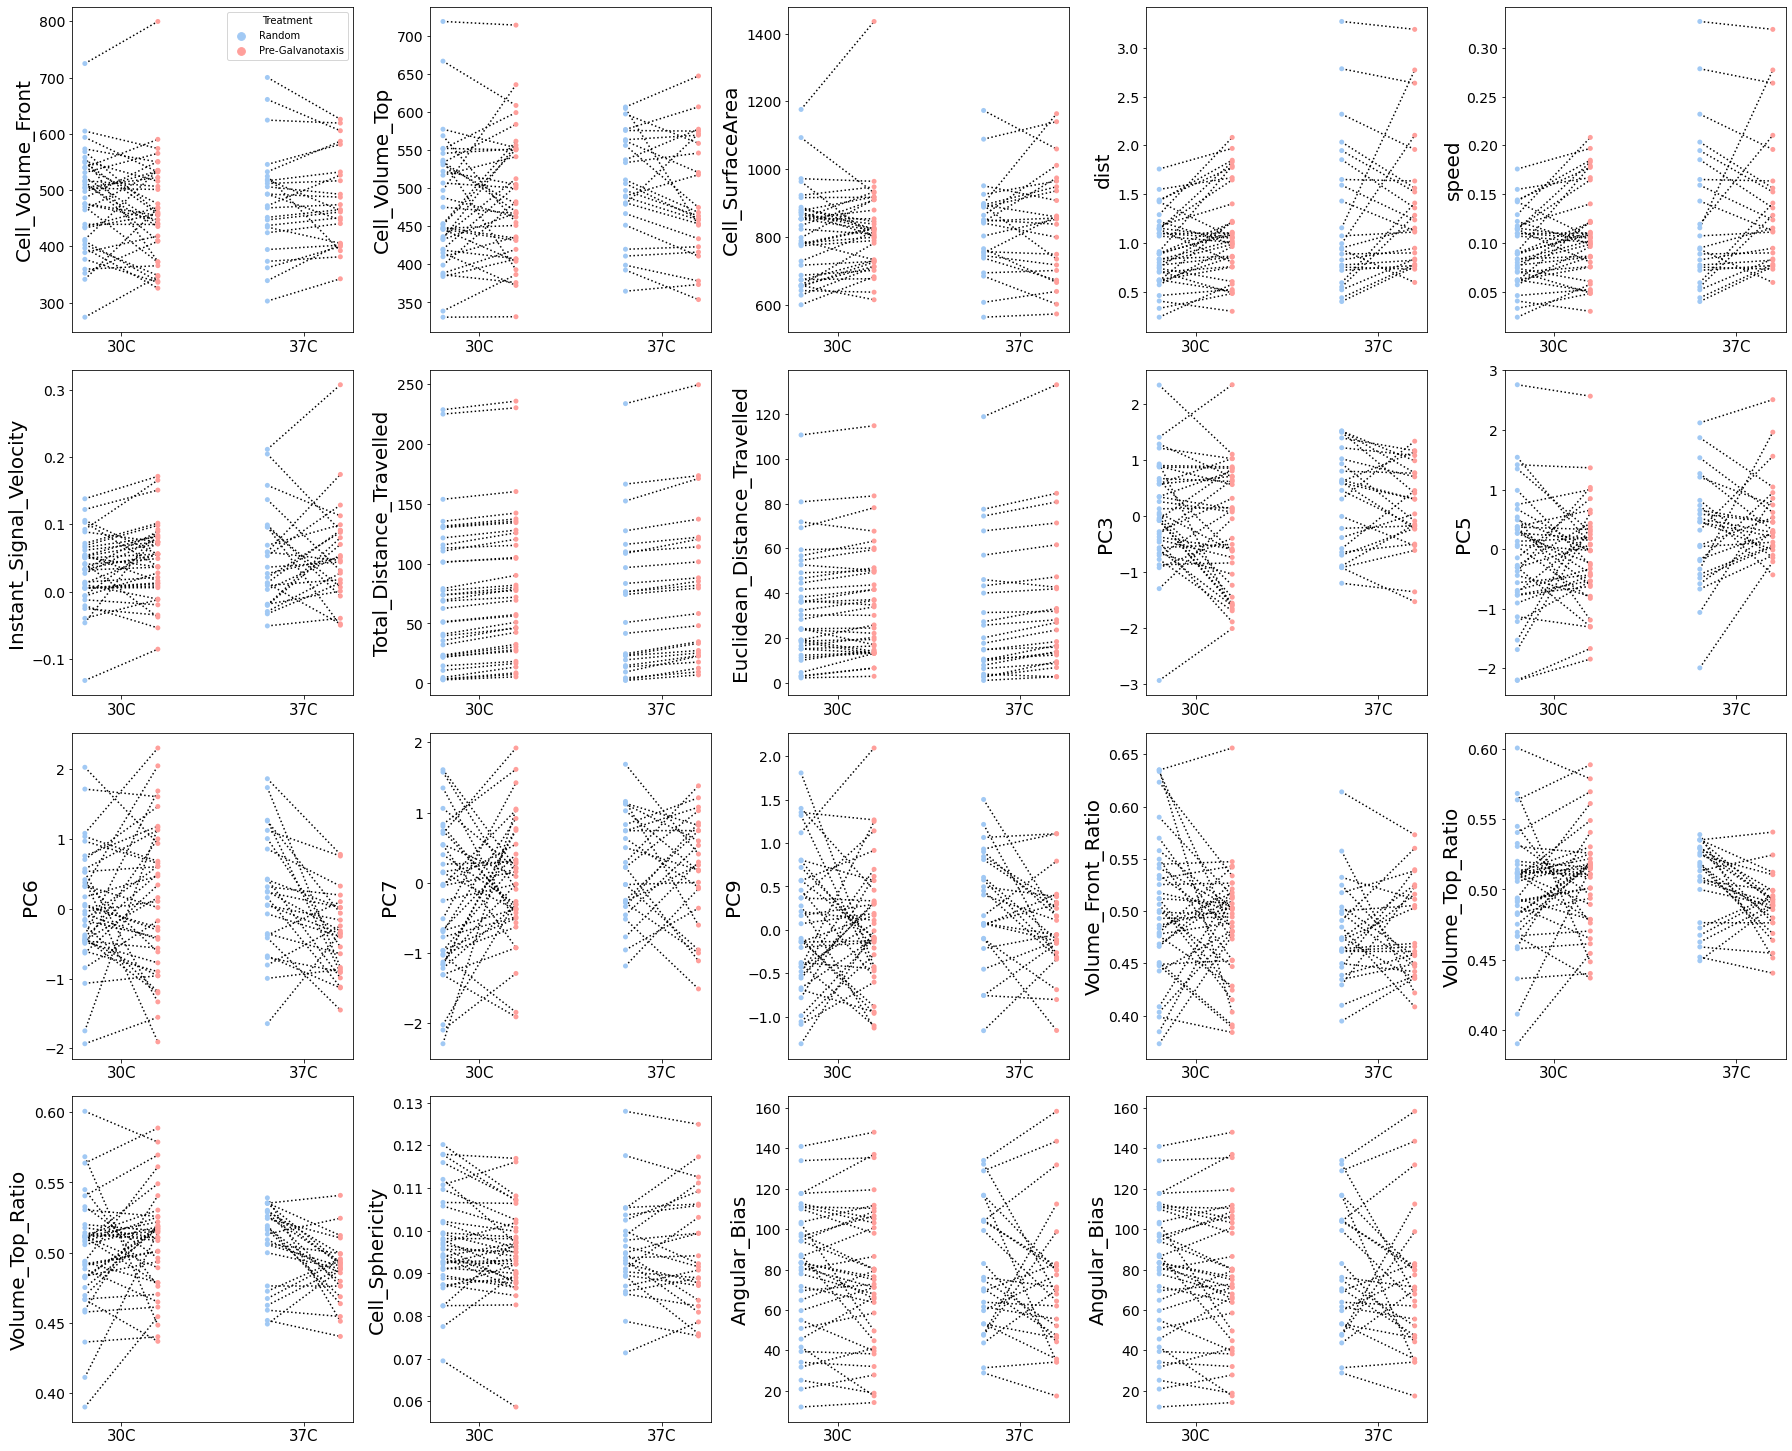

In [154]:
############### Metric distributions by gene #################################

import re

angles = []
for i, row in dfef.iterrows():
    angles.append(distance(row.Trajectory_X,row.Trajectory_Y,row.Trajectory_Z,-1,0,0))
#     angles.append(angle(row.Trajectory_X,row.Trajectory_Y,1,0))
dfef['Angular_Bias'] = angles

#### remove speed outliers
# tempframe = TotalFrame[TotalFrame.speed<0.8]
tempframe = dfef[dfef.Turn_Angle<30]

colorlist = [list(sns.color_palette('pastel').as_hex())[i] for i in [0,3,8]]

smallersig = ['Cell_SurfaceArea','Cell_Volume','Cell_Elongation',
              'Volume_Front_Ratio','Volume_Right_Ratio','speed','persistence',
             'Turn_Angle', 'Cell_TotalAngle','Angular_Bias']
siglabels = ['Cell Surface Area (µm$^2$)','Cell Volume (µm$^3$)','Cell_Elongation (a.u.)',
             'Front-Back Volume Ratio (a.u.)','Right-Left Volume Ratio (a.u.)','Speed (µm/sec)','Persistence (a.u.)',
            'Turn Angle (°)', 'Cell_TotalAngle (°)','Angular Bias (°)']

sp = math.ceil(math.sqrt(len(ptdf[ptdf.p_value<0.05].Metric.values)))
fig, axes = plt.subplots(sp, sp, figsize=(sp*5,sp*5))#, sharex=True)
axli = axes.flatten()

for i, sig in enumerate(ptdf[ptdf.p_value<0.05].Metric.values):
#     vp = sns.violinplot(data=tempframe, x='Treatment', y=sig, hue = 'Temperature', palette = colorlist, inner = None, ax=axli[i], )
    
    bp = sns.stripplot(data=dfef.groupby(['CellID','Treatment','Temperature']).mean().reset_index().dropna(),
                       x='Temperature', y=sig, hue = 'Treatment', palette = colorlist, dodge=True, jitter = 0,ax=axli[i])
    for (x0, y0), (x1, y1) in zip(axli[i].collections[0].get_offsets(), axli[i].collections[1].get_offsets()):
        axli[i].plot([x0, x1], [y0, y1], color='black', ls=':', zorder=0)
    for (x0, y0), (x1, y1) in zip(axli[i].collections[2].get_offsets(), axli[i].collections[3].get_offsets()):
        axli[i].plot([x0, x1], [y0, y1], color='black', ls=':', zorder=0)
#     Q1 = tempframe[sig].quantile(0.25)
#     Q3 = tempframe[sig].quantile(0.75)  
#     IQR = Q3 - Q1
#     axli[i].set_ylim(Q1 - 1.6*IQR, Q3 + 1.6*IQR)
    axli[i].set_ylabel(sig, fontsize=20)
    axli[i].set_xlabel('', fontsize=20)
    axli[i].tick_params('y', labelsize=14)
    axli[i].set_xticklabels(axli[i].get_xticklabels(), fontsize = 15)
    if i>0:
        axli[i].legend_ = None
for a in range(i+1, len(axli)):
    axli[a].remove()

    
plt.tight_layout()
plt.savefig(datadir + 'Temperature comparison paired EF.png', bbox_inches='tight')





There are 40 cells continuously in this time window


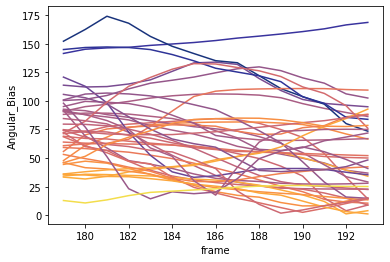

In [175]:
######################## HOW LONG DOES IT TAKE INDIVIDUAL CELLS TO ALIGN BASED ON INITIAL TRAJECTORY #######################
from cmocean import cm

angles = []
for i, row in TotalFrame.iterrows():
    angles.append(distance(row.Trajectory_X,row.Trajectory_Y,row.Trajectory_Z,-1,0,0))
#     angles.append(angle(row.Trajectory_X,row.Trajectory_Y,1,0))
TotalFrame['Angular_Bias'] = angles

#grab only the cells that I saw when the field was applied
baef = np.arange(179,194)#187)
dfe = []
for i, cell in TotalFrame.groupby('CellID'):
    cell = cell.sort_values('frame').reset_index(drop = True)
    cell['Angular_Bias_diff'] = cell.Angular_Bias.diff()
    if all([n in cell.frame.to_list() for n in baef]):
        dfe.append(cell[cell.frame.isin(baef)])
dfalign = pd.concat(dfe)

print(f'There are {len(dfalign.CellID.unique())} cells continuously in this time window')




norm = matplotlib.colors.Normalize()
cmm = cm.thermal_r
norm.autoscale([dfalign.Angular_Bias.min(),dfalign.Angular_Bias.max()])
cb = plt.cm.ScalarMappable(norm=norm, cmap=cmm)


for c, cell in dfalign.groupby('CellID'):
    sns.lineplot(data = cell, x = 'frame', y = 'Angular_Bias', color = cmm(norm(cell.iloc[0].Angular_Bias)))


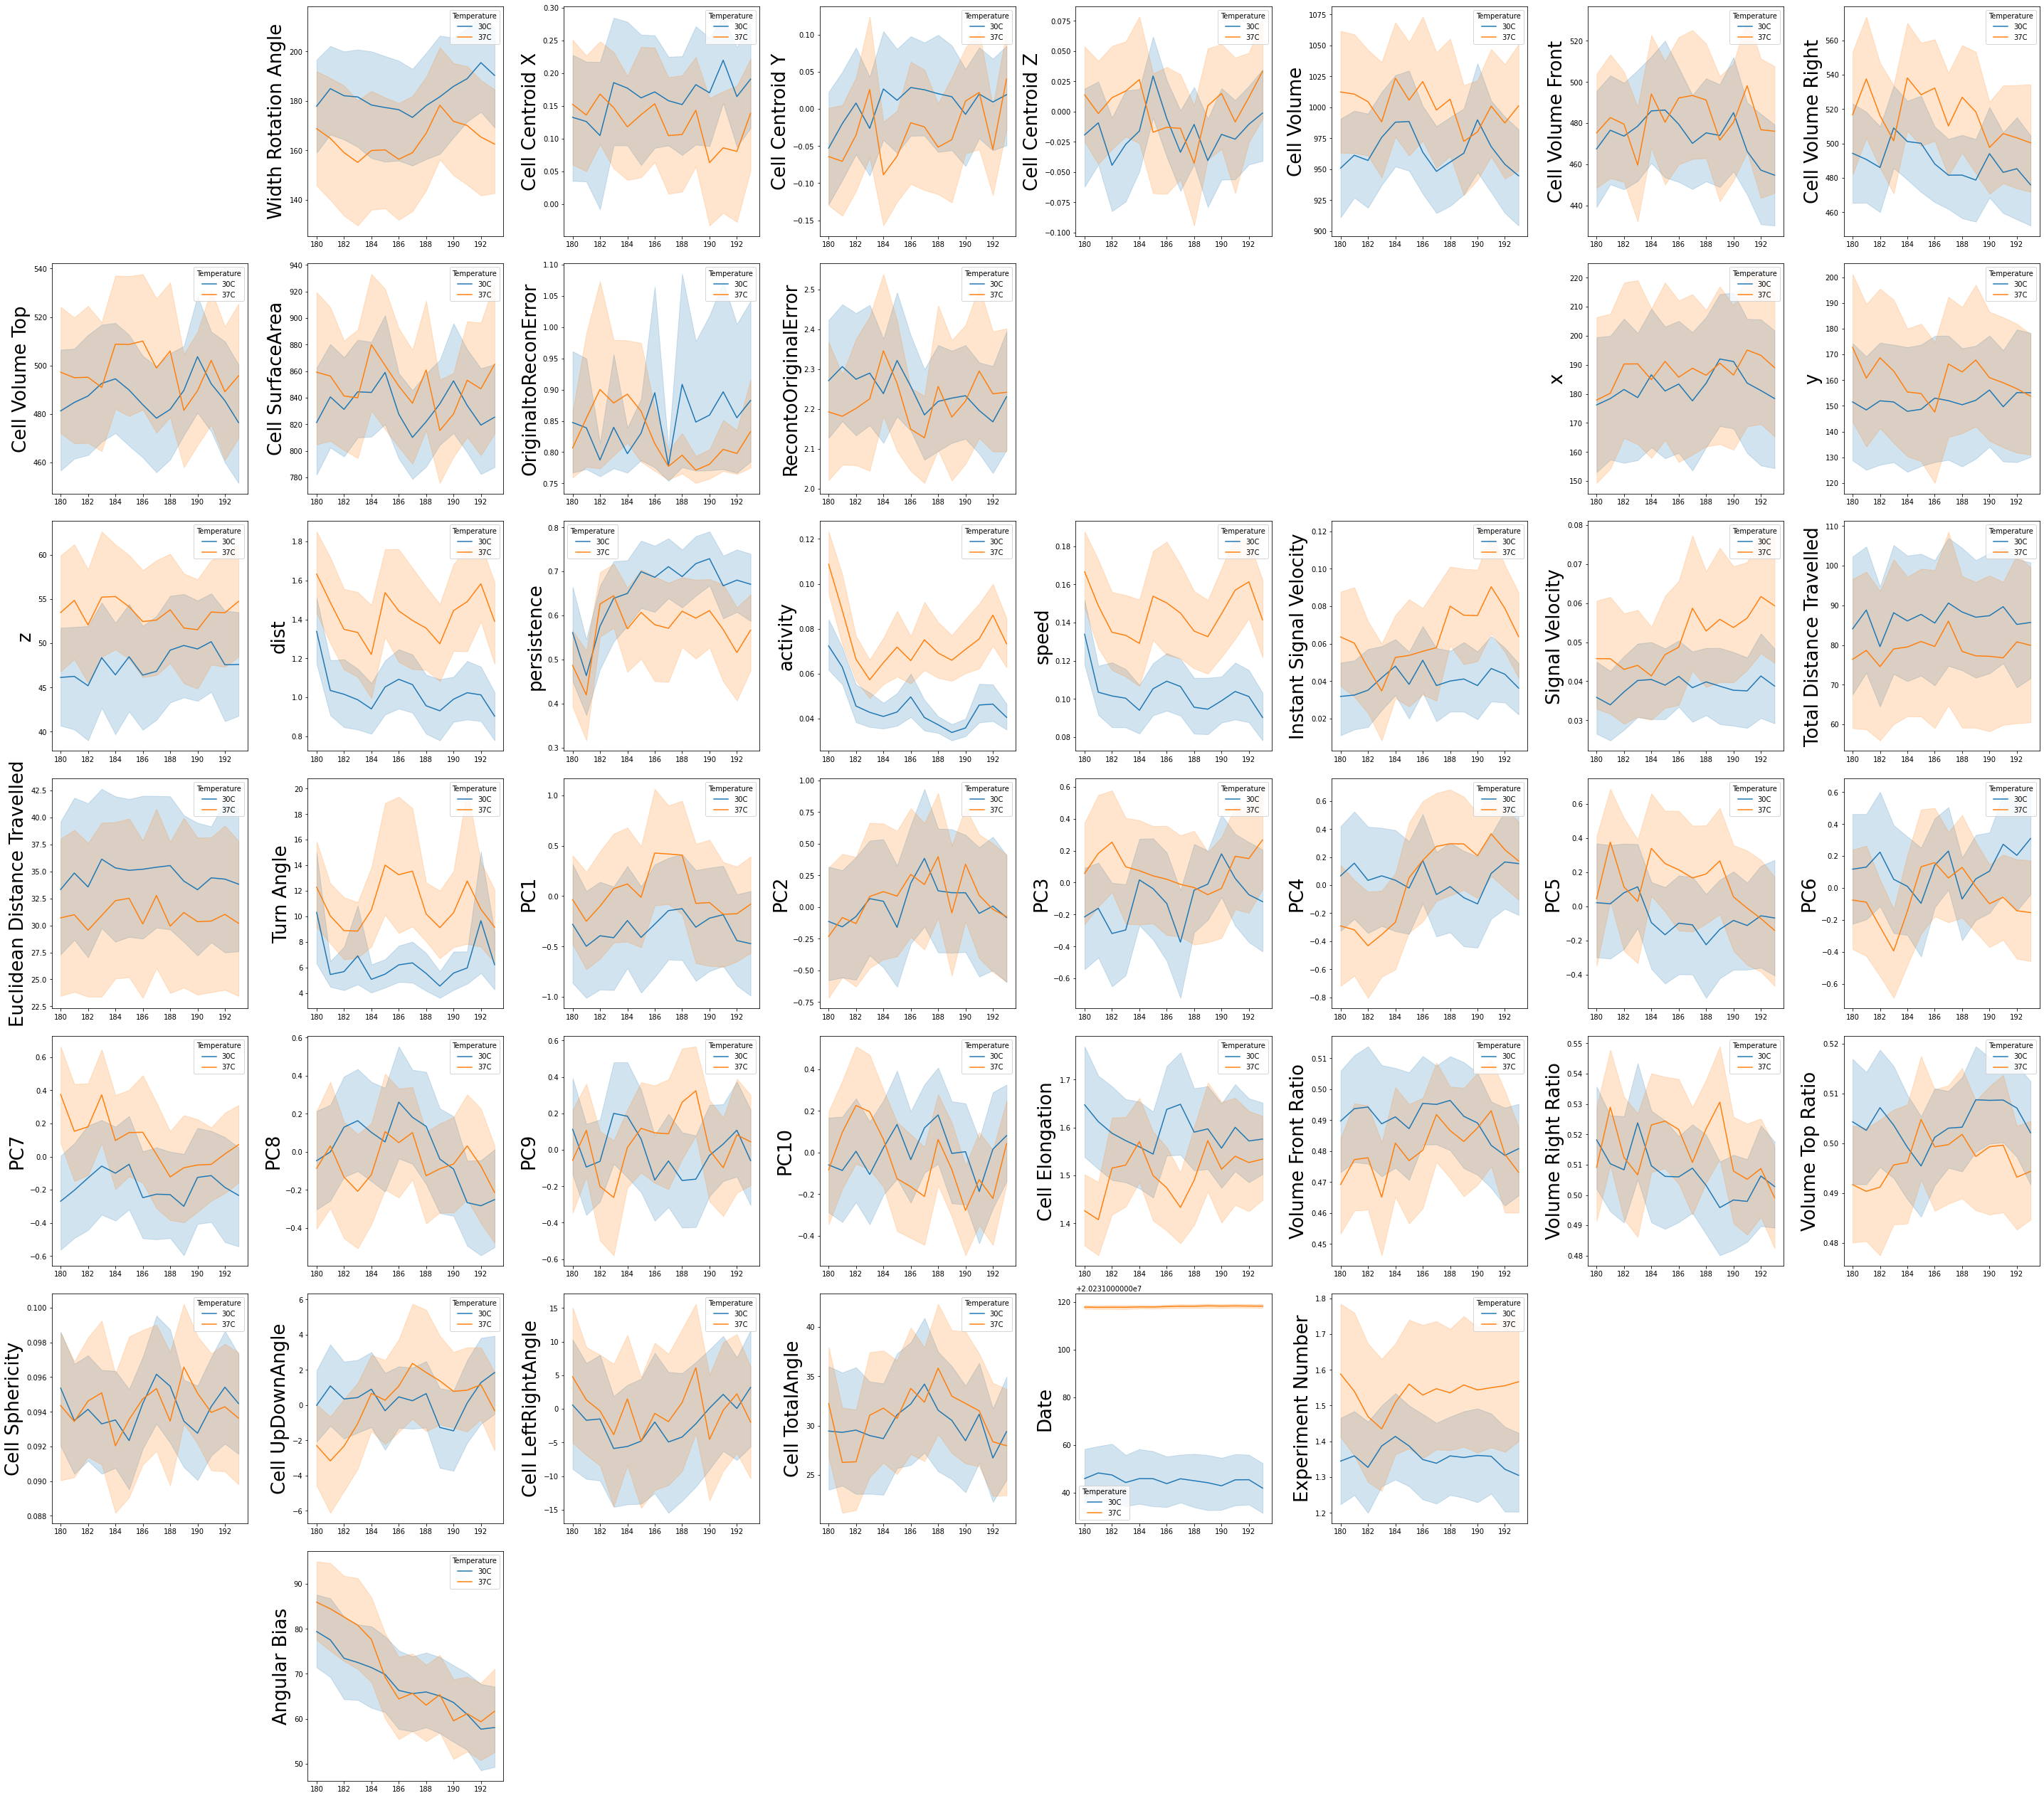

In [155]:
################### WHAT ABOUT JUST LOOKING AT PRE-GALVANOTAXIS OVER TIME ###################


############## graph all of the stats for 30C ###########
moreremove = []
moreremove.extend([i for i in dfef.columns.to_list() if 'Euler' in i])
moreremove.extend([i for i in dfef.columns.to_list() if 'intensity' in i])
moreremove.extend([i for i in dfef.columns.to_list() if 'avg' in i])
moreremove.extend(['cell','CellID'])
ModeFrame = TotalFrame[TotalFrame.Treatment == 'Pre-Galvanotaxis'].copy().drop(columns=to_remove+moreremove).reset_index()
#make subplots
sp = math.ceil(math.sqrt(len(ModeFrame.columns)))
fig, axes = plt.subplots(sp,sp,figsize=(sp*5,sp*5))
axf = axes.flatten()
for i, param in enumerate(ModeFrame.columns.to_list()):
    ax = axf[i]
    if param not in ['frame', 'Treatment','Experiment','Temperature','structure','index']:
    #### use the max and the lowest non zero as min
        sns.lineplot(data = ModeFrame,
            x = 'frame',
            y = param,
            hue = 'Temperature',
            ax = ax,
        )
#         ax.set_xticklabels(
#             [round(x,1) for x in centers.PC1.to_list()],
#             fontsize = 22
#         )
#         ax.set_yticklabels(
#             [round(x,1) for x in centers.PC2.to_list()],
#             rotation=0,
#             fontsize = 22
#         )
#         #take out all axis labels except the desired ones
#         for o, l in enumerate(ax.xaxis.get_ticklabels()):
#             if o%5 != 0:
#                 l.set_visible(False)
#         for o, l in enumerate(ax.yaxis.get_ticklabels()):
#             if o%5 != 0:
#                 l.set_visible(False)
            #set axis titles
        ax.set_xlabel('')
        ax.set_ylabel(param.replace('_',' '), fontsize = 26)
    else:
        ax.remove()
for a in range(i+1,len(axf)):
    axf[a].remove()
    
    
plt.tight_layout()


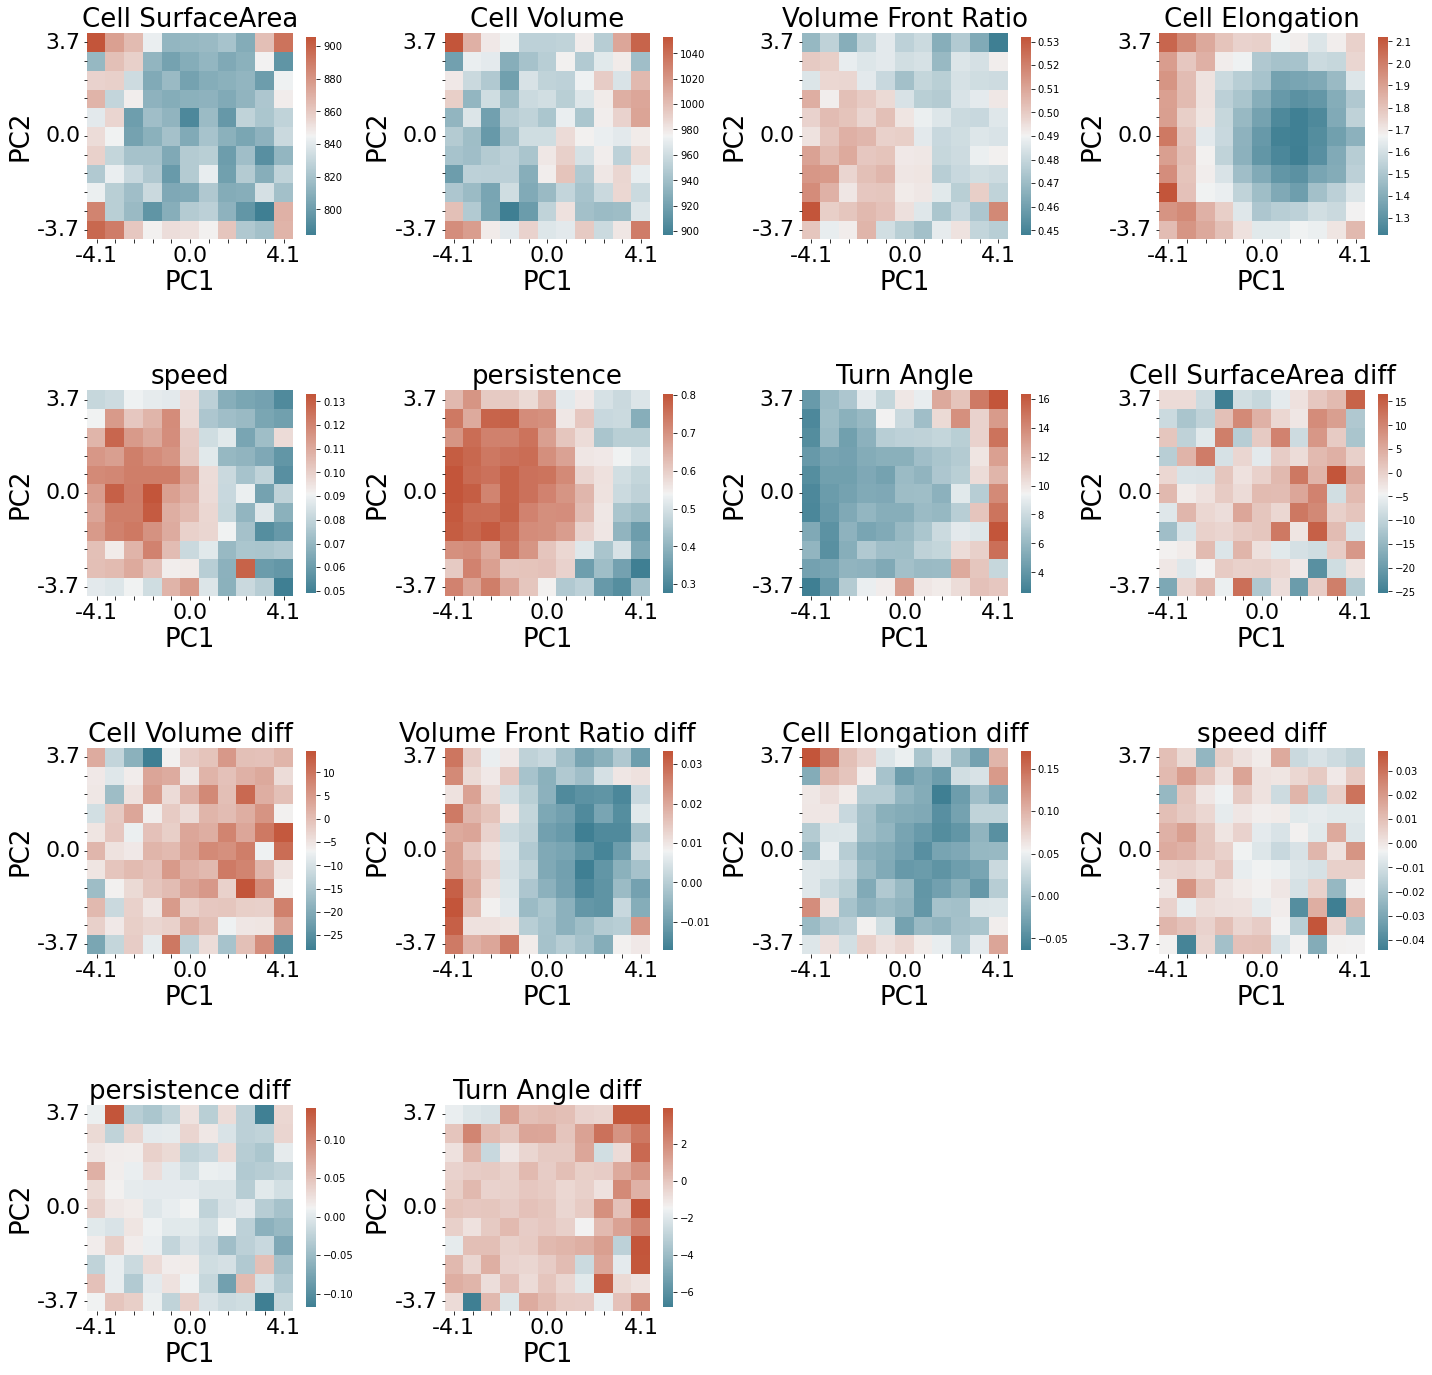

In [11]:
########### PLOT THE DISTRIBUTIONS OF SHAPE METRICS FROM THE SEPARATED MIGRATION MODES #############
############ IN THE COARSE GRAINED PHASE SPACE ###############

#add some metric differentials
metrics = ['Cell_SurfaceArea','Cell_Volume','Volume_Front_Ratio','Cell_Elongation','speed','persistence','Turn_Angle']
TotalFrame = TotalFrame.sort_values(['CellID','frame'])
diffmets = metrics.copy()
for d in metrics:
    TotalFrame[d+'_diff'] = TotalFrame[d].diff()
    diffmets.append(d+'_diff')

#make subplots
sp = math.ceil(math.sqrt(len(diffmets)))
fig, axes = plt.subplots(sp,sp,figsize=(sp*5,sp*5))

for i, ax in enumerate(axes.flatten()):
    if i<len(diffmets):
        ################ heatmap of the given metric #############
        #make numpy array with heatmap data
        bighm = np.zeros((nbins,nbins))
        for x in range(nbins):
            for y in range(nbins):
                current =  TotalFrame[(TotalFrame['PC1bins'] == x+1) & (TotalFrame['PC2bins'] == y+1)]
                if current.empty:
                    bighm[y,x] = 0
                elif len(current)==1:
                    bighm[y,x] = current[diffmets[i]]
                else:
                    bighm[y,x] = current[diffmets[i]].mean()


        #plot heatmap with seaborn
        #### use the max and the lowest non zero as min
        sns.heatmap(
            bighm,
            vmin=np.min(bighm[np.nonzero(bighm)]),
            vmax=bighm.max(), #center=0,
            cmap=sns.diverging_palette(220, 20, n=200),
            square=True,
            xticklabels = True,
            yticklabels = True,
            ax = ax,
            cbar_kws={'shrink': 0.65}
        )
        ax.set_xticklabels(
            [round(x,1) for x in centers.PC1.to_list()],
            fontsize = 22
        )
        ax.set_yticklabels(
            [round(x,1) for x in centers.PC2.to_list()],
            rotation=0,
            fontsize = 22
        )
        #take out all axis labels except the desired ones
        for o, l in enumerate(ax.xaxis.get_ticklabels()):
            if o%5 != 0:
                l.set_visible(False)
        for o, l in enumerate(ax.yaxis.get_ticklabels()):
            if o%5 != 0:
                l.set_visible(False)
        #set axis titles
        ax.set_xlabel('PC1', fontsize = 26)
        ax.set_ylabel('PC2', fontsize = 26)
        #correct axis orientations
        ax.invert_yaxis()
        #set title
        ax.set_title(diffmets[i].replace('_',' '), fontsize = 26)
    else:
        ax.remove()

# adjust colorbar tick label size
# cbar_ax.set_yticklabels(cbar_ax.get_yticklabels(),fontsize=18)
#set axis title
axes.flatten()[0].set_ylabel('PC2', fontsize = 26)

plt.tight_layout()
plt.savefig(savedir + 'PC1_PC2 metric heatmaps.png', bbox_inches='tight')

In [ ]:
########### PLOT THE DISTRIBUTIONS OF SHAPE METRIC DIFFERENTIALS FROM THE SEPARATED MIGRATION MODES #############
############ IN THE COARSE GRAINED PHASE SPACE ###############

metrics = ['Cell_SurfaceArea','Cell_Volume','speed','persistence','Turn_Angle']

sp = math.ceil(math.sqrt(len(metrics)))

fig, axes = plt.subplots(sp,sp,figsize=(sp*5,sp*5))

for i, ax in enumerate(axes.flatten()):
    if i<len(metrics):
        ################ heatmap of the given metric #############
        #make numpy array with heatmap data
        bighm = np.zeros((nbins,nbins))
        for x in range(nbins):
            for y in range(nbins):
                current =  TotalFrame[(TotalFrame['PC1bins'] == x+1) & (TotalFrame['PC2bins'] == y+1)]
                if current.empty:
                    bighm[y,x] = 0
                elif len(current)==1:
                    bighm[y,x] = current[metrics[i]]
                else:
                    bighm[y,x] = current[metrics[i]].mean()


        #plot heatmap with seaborn
        #### use the max and the lowest non zero as min
        sns.heatmap(
            bighm,
            vmin=np.min(bighm[np.nonzero(bighm)]),
            vmax=bighm.max(), #center=0,
            cmap=sns.diverging_palette(220, 20, n=200),
            square=True,
            xticklabels = True,
            yticklabels = True,
            ax = ax,
            cbar_kws={'shrink': 0.65}
        )
        ax.set_xticklabels(
            [round((PC1bins[i+1]+x)/2,1) for i,x in enumerate(PC1bins[:-1])],
            fontsize = 16
        )
        ax.set_yticklabels(
            [round((PC2bins[i+1]+x)/2,1) for i,x in enumerate(PC2bins[:-1])],
            rotation=0,
            fontsize = 16
        )
        #take out all axis labels except the desired ones
        for o, l in enumerate(ax.xaxis.get_ticklabels()):
            if o%5 != 0:
                l.set_visible(False)
        for o, l in enumerate(ax.yaxis.get_ticklabels()):
            if o%5 != 0:
                l.set_visible(False)
        #set axis titles
        ax.set_xlabel('PC1', fontsize = 26)
        ax.set_ylabel('PC2', fontsize = 26)
        #correct axis orientations
        ax.invert_yaxis()
        #set title
        ax.set_title(metrics[i], fontsize = 26)
    else:
        ax.remove()

# adjust colorbar tick label size
cbar_ax.set_yticklabels(cbar_ax.get_yticklabels(),fontsize=18)
#set axis title
axes.flatten()[0].set_ylabel('PC2', fontsize = 26)

plt.tight_layout()
plt.savefig(savedir + 'PC1_PC2 metric heatmaps.png', bbox_inches='tight')

NameError: name 'cbar_ax' is not defined

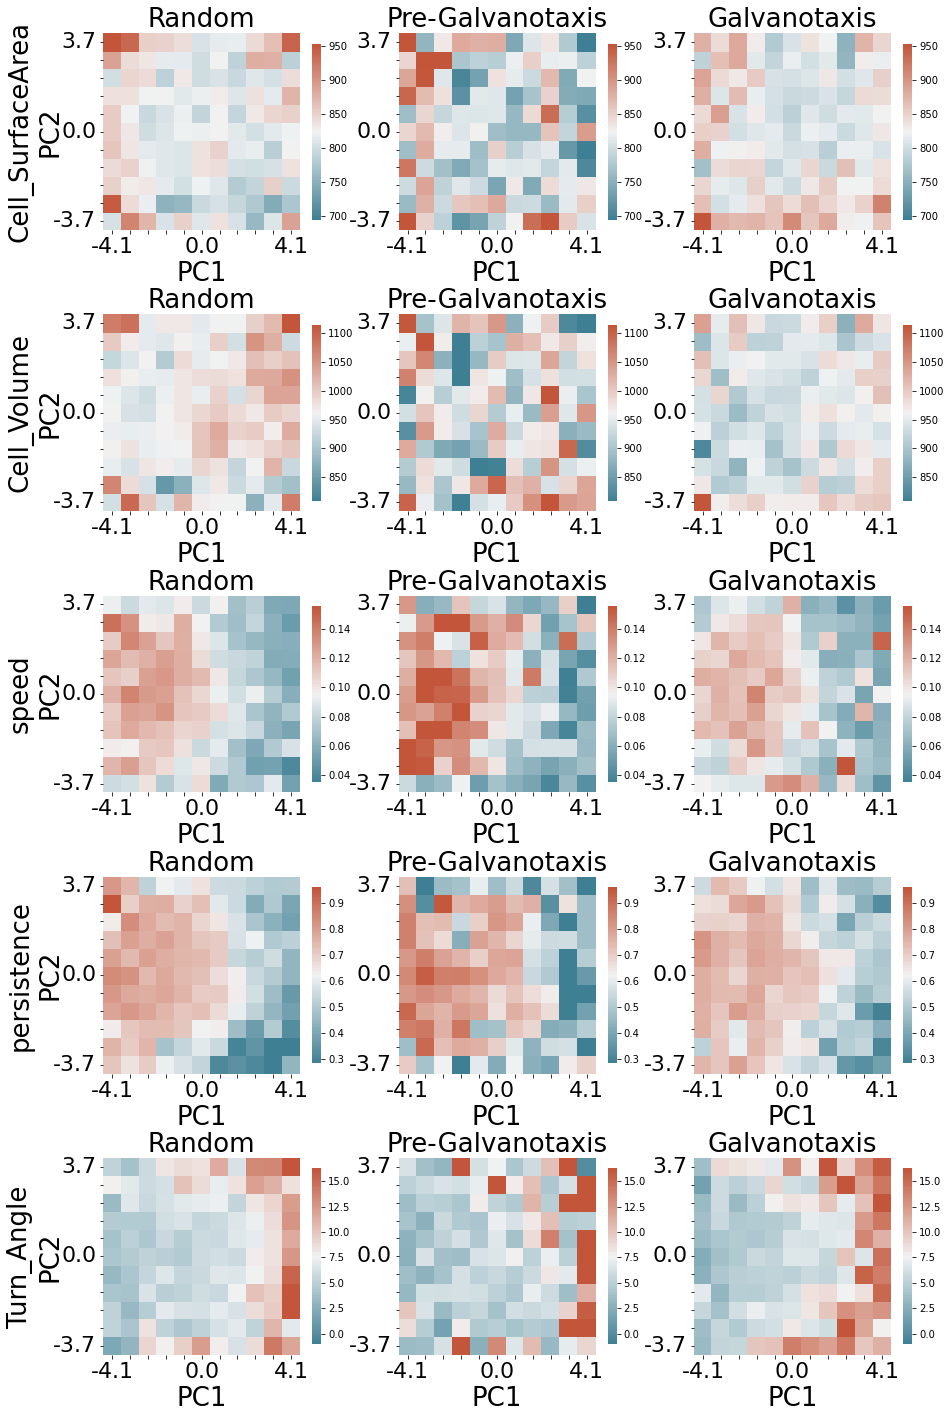

In [10]:
########### PLOT THE DISTRIBUTIONS OF SHAPE METRICS FROM THE SEPARATED MIGRATION MODES #############
############ IN THE COARSE GRAINED PHASE SPACE ###############

metrics = ['Cell_SurfaceArea','Cell_Volume','speed','persistence','Turn_Angle']

sp = math.ceil(math.sqrt(len(metrics)))

fig, axes = plt.subplots(len(metrics),len(TotalFrame.Migration_Mode.unique()),figsize=(15,len(metrics)*5))


for i, met in enumerate(metrics):
    for a, ax in enumerate(axes[i]):
        mm = TotalFrame.Migration_Mode.unique()[a]
        mdf = TotalFrame[TotalFrame.Migration_Mode==mm]
        ################ heatmap of the given metric #############
        #make numpy array with heatmap data
        bighm = np.zeros((len(axes[i]),nbins,nbins))
        for n in range(bighm.shape[0]):
            mdf = TotalFrame[TotalFrame.Migration_Mode==TotalFrame.Migration_Mode.unique()[n]]
            for x in range(nbins):
                for y in range(nbins):
                    current =  mdf[(mdf['PC1bins'] == x+1) & (mdf['PC2bins'] == y+1)].dropna(subset=[met])
                    if current.empty:
                        bighm[n,y,x] = 0
                    elif len(current)==1:
                        bighm[n,y,x] = current[met]
                    else:
                        bighm[n,y,x] = current[met].mean()


        #plot heatmap with seaborn
        #### use the max and the lowest non zero as min
        sns.heatmap(
            bighm[a,:,:],
            vmin=np.mean(bighm[np.nonzero(bighm)])-(bighm.std()*2),
            vmax=np.mean(bighm)+(bighm.std()*2), #center=0,
            cmap=sns.diverging_palette(220, 20, n=200),
            square=True,
            xticklabels = True,
            yticklabels = True,
            ax = ax,
            cbar_kws={'shrink': 0.75}
        )
        ax.set_xticklabels(
            [round(x,1) for x in centers.PC1.to_list()],
            fontsize = 22
        )
        ax.set_yticklabels(
            [round(x,1) for x in centers.PC2.to_list()],
            rotation=0,
            fontsize = 22
        )
        #take out all axis labels except the desired ones
        for o, l in enumerate(ax.xaxis.get_ticklabels()):
            if o%5 != 0:
                l.set_visible(False)
        for o, l in enumerate(ax.yaxis.get_ticklabels()):
            if o%5 != 0:
                l.set_visible(False)
        #set axis titles
        ax.set_xlabel('PC1', fontsize = 26)      
        if (a == 0):
            ax.set_ylabel(f'{met}\nPC2', fontsize = 26, labelpad=-10)
#         else:
#             ax.set_ylabel(f'PC2', fontsize = 26, labelpad=-10)
        #correct axis orientations
        ax.invert_yaxis()
        #set title
        ax.set_title(mm, fontsize = 26)


# adjust colorbar tick label size
cbar_ax.set_yticklabels(cbar_ax.get_yticklabels(),fontsize=18)
#set axis title

plt.tight_layout()
plt.savefig(savedir + 'PC1_PC2 metric heatmaps separated.png', bbox_inches='tight')

C:\Users\Aaron\AppData\Roaming\Python\Python37\site-packages\scipy\stats\stats.py:3621: F_onewayBadInputSizesWarning: at least one input has length 0
  warnings.warn(F_onewayBadInputSizesWarning('at least one input '


Name Cell_Centroid_X          Multiple Comparison of Means - Tukey HSD, FWER=0.05         
      group1          group2   meandiff p-adj  lower    upper  reject
---------------------------------------------------------------------
Chem_Directed_Chem   Galv_Galv  13.8299   0.0  12.5991 15.0607   True
Chem_Directed_Chem Random_Chem   2.3165   0.0   1.1808  3.4522   True
Chem_Directed_Chem Random_Galv   6.5544   0.0   5.2757  7.8331   True
         Galv_Galv Random_Chem -11.5134   0.0 -12.6137 -10.413   True
         Galv_Galv Random_Galv  -7.2755   0.0  -8.5229 -6.0281   True
       Random_Chem Random_Galv   4.2379   0.0   3.0842  5.3916   True
---------------------------------------------------------------------
Name Cell_Centroid_Y          Multiple Comparison of Means - Tukey HSD, FWER=0.05         
      group1          group2   meandiff p-adj   lower   upper  reject
---------------------------------------------------------------------
Chem_Directed_Chem   Galv_Galv   4.8776    0.0  

Name Cell_intensity_99pct          Multiple Comparison of Means - Tukey HSD, FWER=0.05          
      group1          group2   meandiff p-adj   lower    upper  reject
----------------------------------------------------------------------
Chem_Directed_Chem   Galv_Galv  -6.9099    0.0 -10.4941 -3.3257   True
Chem_Directed_Chem Random_Chem   9.9033    0.0    6.596 13.2106   True
Chem_Directed_Chem Random_Galv  -2.6488 0.2602  -6.3725  1.0749  False
         Galv_Galv Random_Chem  16.8132    0.0  13.6089 20.0175   True
         Galv_Galv Random_Galv   4.2611 0.0138   0.6286  7.8937   True
       Random_Chem Random_Galv -12.5521    0.0 -15.9117 -9.1924   True
----------------------------------------------------------------------
Name Cell_intensity_max          Multiple Comparison of Means - Tukey HSD, FWER=0.05          
      group1          group2   meandiff p-adj   lower    upper  reject
----------------------------------------------------------------------
Chem_Directed_Chem   Galv_G

Name PC8          Multiple Comparison of Means - Tukey HSD, FWER=0.05         
      group1          group2   meandiff p-adj   lower   upper  reject
---------------------------------------------------------------------
Chem_Directed_Chem   Galv_Galv   1.4552    0.0  1.2838  1.6265   True
Chem_Directed_Chem Random_Chem   0.3745    0.0  0.2164  0.5326   True
Chem_Directed_Chem Random_Galv   1.2123    0.0  1.0343  1.3903   True
         Galv_Galv Random_Chem  -1.0807    0.0 -1.2339 -0.9275   True
         Galv_Galv Random_Galv  -0.2429 0.0019 -0.4165 -0.0692   True
       Random_Chem Random_Galv   0.8378    0.0  0.6772  0.9984   True
---------------------------------------------------------------------
Name PC9          Multiple Comparison of Means - Tukey HSD, FWER=0.05         
      group1          group2   meandiff p-adj   lower   upper  reject
---------------------------------------------------------------------
Chem_Directed_Chem   Galv_Galv   0.1491 0.0833 -0.0127  0.3108  False
Ch

Name nucleus_Structure_intensity_1pct       Multiple Comparison of Means - Tukey HSD, FWER=0.05       
      group1          group2   meandiff p-adj lower upper reject
----------------------------------------------------------------
Chem_Directed_Chem   Galv_Galv      nan   nan   nan   nan  False
Chem_Directed_Chem Random_Chem      nan   nan   nan   nan  False
Chem_Directed_Chem Random_Galv      nan   nan   nan   nan  False
         Galv_Galv Random_Chem      nan   nan   nan   nan  False
         Galv_Galv Random_Galv      nan   nan   nan   nan  False
       Random_Chem Random_Galv      nan   nan   nan   nan  False
----------------------------------------------------------------
Name nucleus_Structure_intensity_99pct       Multiple Comparison of Means - Tukey HSD, FWER=0.05       
      group1          group2   meandiff p-adj lower upper reject
----------------------------------------------------------------
Chem_Directed_Chem   Galv_Galv      nan   nan   nan   nan  False
Chem_Directed

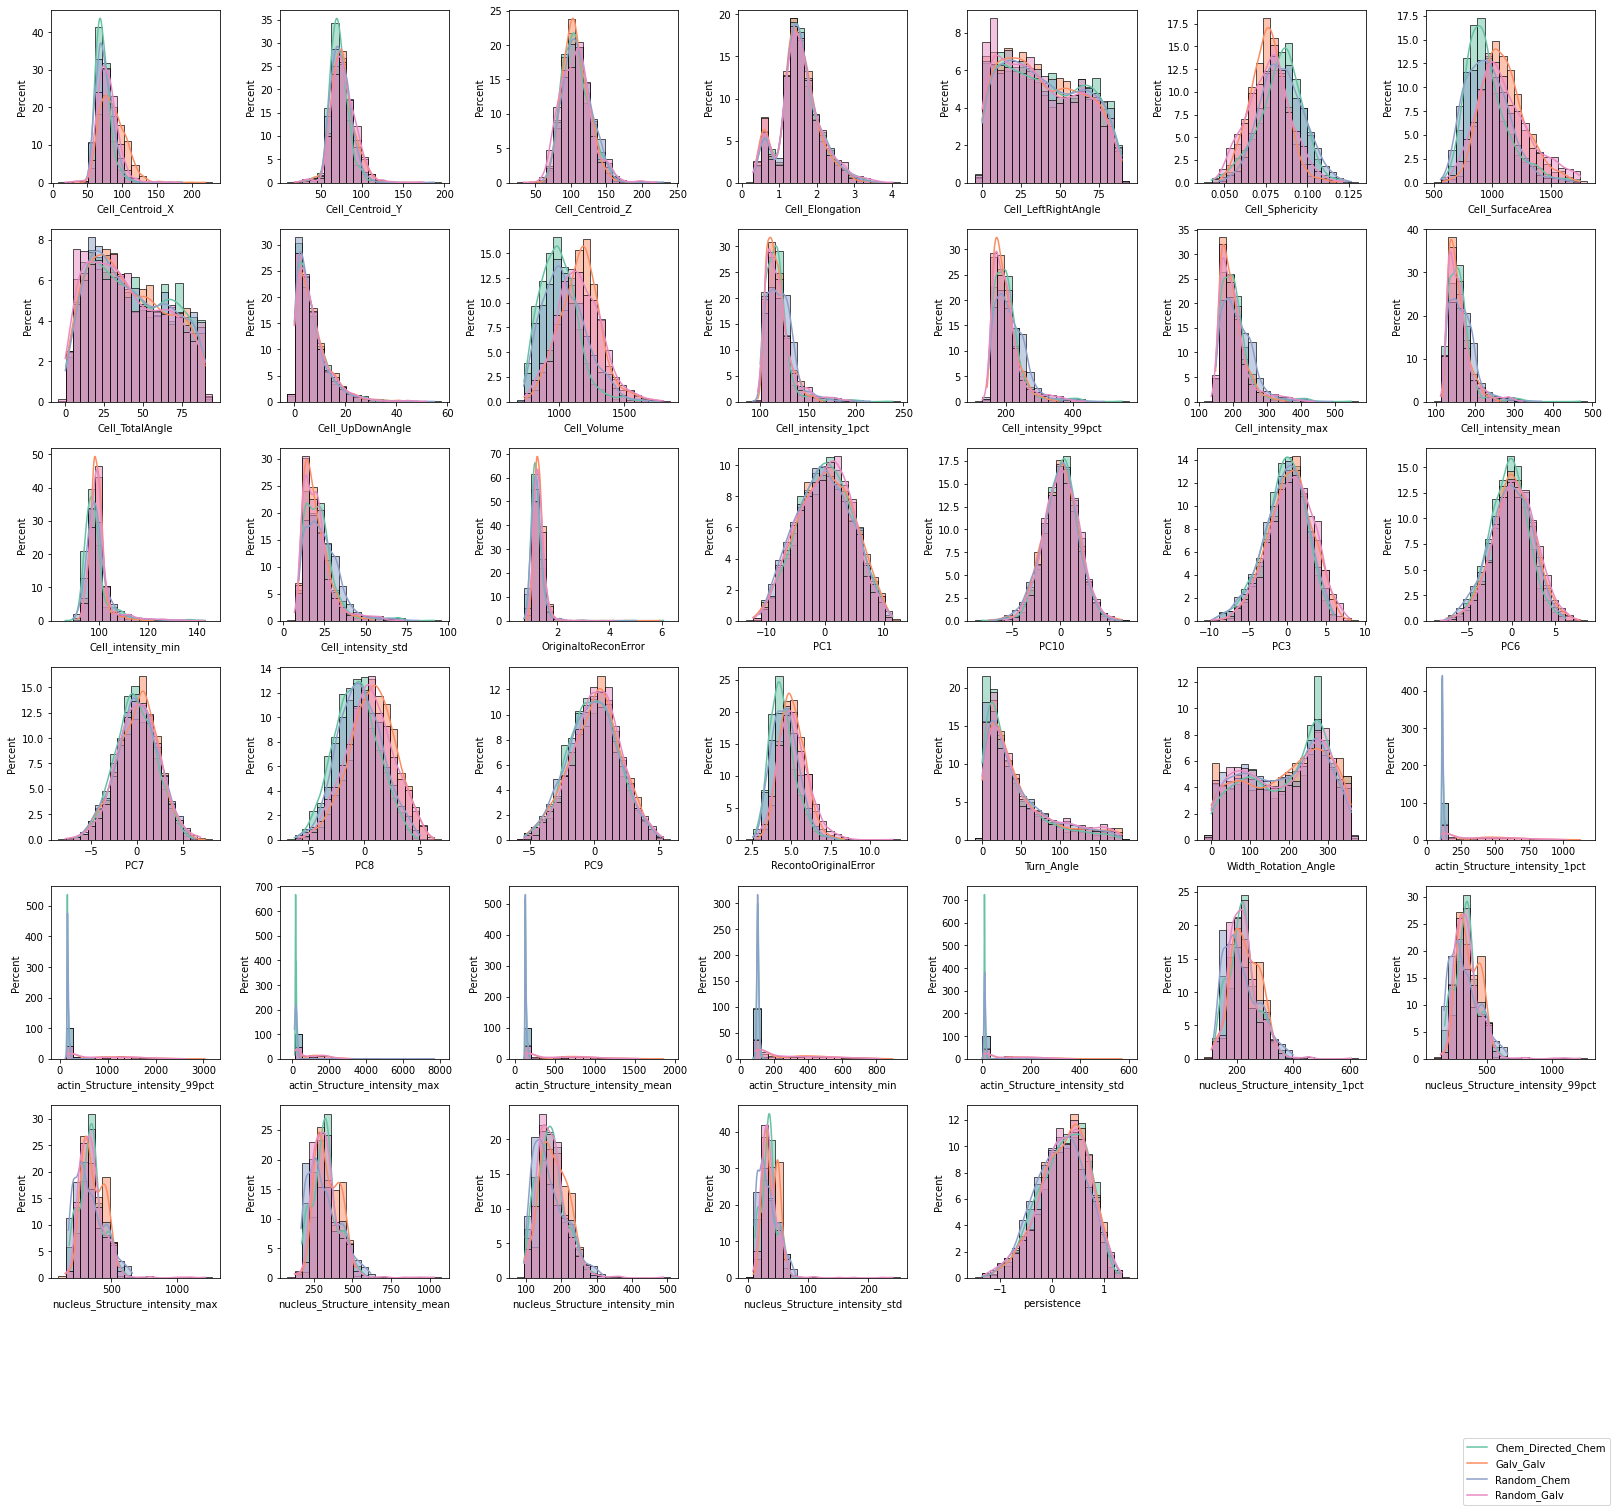

In [68]:
############### get list of metrics that are significant by migration mode using anova ############
ModeFrame = TotalFrame.copy()

import scipy.stats as ss
siglist = []
new_remove = to_remove.copy()
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'cell' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'frame' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'angle' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'avg' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'dist' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'activity' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'structure' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'ID' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'Experiment' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'Migration_Mode' in x])

for c in ModeFrame.drop(columns=new_remove).columns.to_list():
    samples = [g[1].dropna() for g in ModeFrame.groupby(['Migration_Mode','Experiment'])[c]]
    f_val, p_val = ss.f_oneway(*samples)
#     print(f'Name: {c}, F value: {f_val}, p value: {p_val}')
    if p_val < 0.05:
        siglist.append(c) 
siglist = sorted(siglist)
from statsmodels.stats.multicomp import pairwise_tukeyhsd
for c in siglist:
    print(f'Name {c}', pairwise_tukeyhsd(ModeFrame[c], 
                                         [one+'_'+two for one, two in zip(ModeFrame['Migration_Mode'].to_list(), ModeFrame['Experiment'].to_list())]))

# units= ['(a.u.)','(a.u.)','(µm$^3$)','(a.u.)','(a.u.)','(µm$^2$)','(µm$^3$)',
#         '(a.u.)','(a.u.)']


################# LOOK AT STAT DISTRIBUTIONS OF SIGNIFICANT STATS ######################
import seaborn as sns

colors = sns.color_palette("Set2")
colors = list(colors.as_hex())


# colors = list(sns.color_palette('deep').as_hex())

CoRo = math.ceil(math.sqrt(len(siglist)))
row = 0
fig, axes = plt.subplots(CoRo, CoRo, figsize=(3.2*CoRo,3*CoRo))#, sharex=True)

for i, met in enumerate(siglist):

    
    #get the metric in question separated by migration mode
    samples = [g[1].dropna() for g in ModeFrame.groupby(['Migration_Mode','Experiment'])[met]]
    
        
    #get bins so that the widths between all types are the same
    maxx = max([max(x) for x in samples])
    minn = min([min(x) for x in samples])
    binwidth = (maxx-minn)*0.05
    maxx = maxx + binwidth
    minn = minn - binwidth
    binss = np.linspace(minn,maxx,round((maxx-minn)/binwidth))
    
    #plot the data
    ax = axes[row,(i-((CoRo-1)*row)-row)]
    sns.histplot(ax = ax, data=samples[0], bins=binss, stat='percent', color = colors[0], kde = True)
    sns.histplot(ax = ax, data=samples[1], bins=binss, stat='percent', color = colors[1], kde = True)
    sns.histplot(ax = ax, data=samples[2], bins=binss, stat='percent', color = colors[2], kde = True)
    sns.histplot(ax = ax, data=samples[3], bins=binss, stat='percent', color = colors[3], kde = True)
#     ax.set_ylabel(met)#, fontsize = 1.75*CoRo)
    if (i+1)%(CoRo) ==0:
        row = row + 1


ax = axes[row,(i-((CoRo-1)*row)-row)]
fig.legend(['_'.join(g) for g, i in ModeFrame.groupby(['Migration_Mode','Experiment'])], loc = 'lower right')

#delete all of the subplots that are unused
for a in range(i,CoRo**2):
    fig.delaxes(axes[row,(a-((CoRo-1)*row)-row)])
    if (a+1)%(CoRo) ==0:
        row = row + 1

# #     ax.set_ylabel(Nucleus_Metrics.iloc[:,i].name)

# # axes[0,0].set_title("Cell", fontsize = 16)
# # axes[0,1].set_title("Nucleus", fontsize = 16)
# # [ax.set_xlabel("Component value") for ax in axes[-1,:]];
# plt.legend(ModeFrame.Migration_Mode.unique(), loc ='lower right')
plt.tight_layout()
# plt.savefig(folder_fl + 'Significant Shape Metric Histograms.png', bbox_inches='tight')

In [20]:
savedir

'D:/Aaron/Data/Chem_Galv_Combined/'